Using TensorFlow backend.
C:\Users\barreau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\barreau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\barreau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\barreau\Anaconda3\lib\site-packages\tensorflow\python\framework\d

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.7502
Epoch 2/1000
10/10 [==============================] - 0s 199us/step - loss: 0.1893
Epoch 3/1000
10/10 [==============================] - 0s 198us/step - loss: 0.1825
Epoch 4/1000
10/10 [==============================] - 0s 298us/step - loss: 0.2752
Epoch 5/1000
10/10 [==============================] - 0s 298us/step - loss: 0.2311
Epoch 6/1000
10/10 [==============================] - 0s 199us/step - loss: 0.1402
Epoch 7/1000
10/10 [==============================] - 0s 248us/step - loss: 0.0901
Epoch 8/1000
10/10 [==============================] - 0s 198us/step - loss: 0.1029
Epoch 9/1000
10/10 [==============================] - 0s 199us/step - loss: 0.1332
Epoch 10/1000
10/10 [==============================] - 0s 298us/step - loss: 0.1332
Epoch 11/1000
10/10 [==============================] - 0s 199us/step - loss

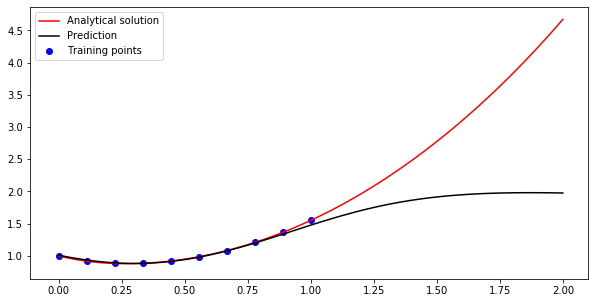

<Figure size 432x288 with 0 Axes>

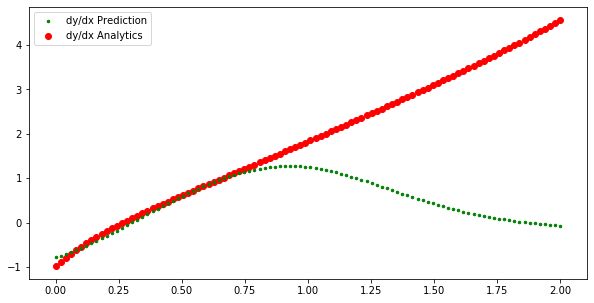

0.0006936957765285832
0.0006936957765285832
0.8691894930474133


<Figure size 432x288 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 22 09:52:29 2020

@author: barreau
"""

import numpy as np
np.random.seed(1234)
import time

from keras.models import Model
from keras.layers import Dense, Input
import keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 

# Analytical solution
Psia = lambda x: np.exp(x**2/2)/(1+x+x**3)+x**2
noise = 0

def dPsia(x,h=0.01):
    return (Psia(x+h)-Psia(x))/h

X_train = np.linspace(0,1,10)
y_train = np.array([Psia(x) + noise*np.random.normal(0,0.1) for x in X_train])
y_true = np.array([Psia(x) for x in X_train])

X = np.linspace(0,2,100)
y = np.array([Psia(x) for x in X])

# normalizedInput = MinMaxScaler()
# normalizedInput.fit(X_train.reshape(-1,1))
# X_train = normalizedInput.transform(X_train.reshape(-1,1))
# X_norm = normalizedInput.transform(X.reshape(-1,1))

# standardOutput = StandardScaler()
# standardOutput.fit(y_train.reshape(-1,1))
# y_train = standardOutput.transform(y_train.reshape(-1,1))
# y_norm = standardOutput.transform(y.reshape(-1,1))

# define the keras model

def f(x, y):
    a = x + (1 + 3*x**2)/(1 + x + x**3)
    b = x**3 + 2*x + x**2*(1 + 3*x**2)/(1 + x + x**3)
    return a*y - b

def custom_loss_wrapper(input_tensor):
    def custom_loss(y_true, y_pred):
        MSEu = K.mean((y_pred - y_true)**2, axis=-1)
        
        # Time derivative
        yt = K.gradients(y_pred, input_tensor)[-1];
        
        MSEf = K.mean(K.square(yt + f(input_tensor, y_pred)), axis=-1)
        return 1*MSEu + 0.01*MSEf
    return custom_loss

input_tensor = Input(shape=(1,))
hidden = input_tensor
for i in range(11):
    hidden = Dense(50, activation='tanh')(hidden)
output_tensor = Dense(1, activation='linear')(hidden)
model = Model(input_tensor, output_tensor)
model.compile(loss=custom_loss_wrapper(input_tensor), optimizer="adam")

tic = time.perf_counter()
model.fit(X_train, y_train, epochs=1000, verbose=1)
toc = time.perf_counter()
print(f"Training time: {toc - tic:0.4f} seconds")

# prediction = standardOutput.inverse_transform(model.predict(X))
prediction = model.predict(X)

plt.figure(figsize=(10,5))
plt.plot(X, y, color='red', label='Analytical solution')
plt.plot(X, prediction, color='black', label = 'Prediction')
plt.scatter(X_train, y_train, color='blue', label='Training points')
plt.legend()
plt.show()
plt.tight_layout()

get_grads = K.gradients(model.output, model.input)[-1]
function_grad_x = K.function([model.input], get_grads)
grads_x = function_grad_x([X.reshape(-1,1)])
dy = [dPsia(x) for x in X]

plt.figure(figsize=(10,5))
plt.scatter(X, dy, color='red', label='dy/dx Analytics')
plt.plot(X, grads_x, 'g.', markersize=5, label='dy/dx Prediction')
plt.legend()
plt.show()
plt.tight_layout()

print(np.mean((model.predict(X_train) - y_train.reshape(-1,1))**2))
print(np.mean((model.predict(X_train) - y_true.reshape(-1,1))**2))
print(np.mean((prediction - y.reshape(-1,1))**2))